# Netflix Content Analysis and Recommendation System

### Student ID: 23346795
### MSc in Data Analytics (MSCDAD JAN25A I)

# 1. Introduction and Dataset Overview

1. This notebook analyzes the "Netflix Movies and TV Shows" dataset from Kaggle
2. Source : https://www.kaggle.com/datasets/ariyoomotade/netflix-data-cleaning-analysis-and-visualization/data
3. The goal is to create a content-based recommendation system that can suggest similar
4. movies and TV shows based on features like genres, title, directors, and country of origin
5. This is an unsupervised learning problem using text-based features and similarity metrics
6. Key features include: title, director,rating, country, listed_in, duration, type (Movie/TV Show)

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import ast
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [7]:
# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# 2. Data Loading and Initial Exploration

In [9]:
print("Loading the Netflix dataset...")

# Load the dataset

netflix_df = pd.read_csv('netflix1.csv')

print(f"Dataset loaded successfully with {netflix_df.shape[0]} rows and {netflix_df.shape[1]} columns")

Loading the Netflix dataset...
Dataset loaded successfully with 8790 rows and 10 columns


In [10]:
# Display basic information about the dataset
print("\nDataset Information:")
netflix_df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


In [11]:
print("\nFirst 5 rows of the dataset:")
netflix_df.head()


First 5 rows of the dataset:


show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
4      s8    Movie                           Sankofa     Haile Gerima   

         country date_added  release_year rating  duration  \
0  United States  9/25/2021          2020  PG-13    90 min   
1         France  9/24/2021          2021  TV-MA  1 Season   
2  United States  9/24/2021          2021  TV-MA  1 Season   
3         Brazil  9/22/2021          2021  TV-PG    91 min   
4  United States  9/24/2021          1993  TV-MA   125 min   

                                           listed_in  
0                                      Documentaries  
1  Crime TV Shows, International TV Shows, TV Act...  
2                 TV Dramas, TV Horror, TV Mysteries  
3                 Children & Family Movies, Comedies  
4   Dramas, Independent Movies, International Movies

In [12]:
print("\nSummary statistics for numerical columns:")
netflix_df.describe()


Summary statistics for numerical columns:


release_year
count   8790.000000
mean    2014.183163
std        8.825466
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000

In [13]:
# Check unique values in categorical columns
categorical_cols = netflix_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols[:5]:  # Limit to first 5 categorical columns to avoid cluttering output
    print(f"\nUnique values in {col}: {netflix_df[col].nunique()}")
    print(f"Sample values: {netflix_df[col].unique()[:5]}")


Unique values in show_id: 8790
Sample values: ['s1' 's3' 's6' 's14' 's8']

Unique values in type: 2
Sample values: ['Movie' 'TV Show']

Unique values in title: 8787
Sample values: ['Dick Johnson Is Dead' 'Ganglands' 'Midnight Mass'
 'Confessions of an Invisible Girl' 'Sankofa']

Unique values in director: 4528
Sample values: ['Kirsten Johnson' 'Julien Leclercq' 'Mike Flanagan' 'Bruno Garotti'
 'Haile Gerima']

Unique values in country: 86
Sample values: ['United States' 'France' 'Brazil' 'United Kingdom' 'India']


In [14]:
# Check for missing values
missing_values = netflix_df.isnull().sum()
missing_percentage = (missing_values / len(netflix_df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})
print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])


Missing Values Analysis:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


# 3. Data Preprocessing and Cleaning

In [16]:
print("\n\nStarting Data Preprocessing and Cleaning...")

# 3.1 Handle Missing Values
print("\n3.1 Handling Missing Values")

# Create a copy of the dataframe for preprocessing
netflix_clean = netflix_df.copy()



Starting Data Preprocessing and Cleaning...

3.1 Handling Missing Values


In [17]:
# Handle missing values in 'director' column (creative content)
if 'director' in netflix_clean.columns and netflix_clean['director'].isnull().sum() > 0:
    netflix_clean['director'] = netflix_clean['director'].fillna('Unknown Director')
    print(f"Filled missing values in 'director' with 'Unknown Director'")

In [18]:
# Handle missing values in 'country' column (categorical)
if 'country' in netflix_clean.columns and netflix_clean['country'].isnull().sum() > 0:
    # Get most frequent country
    mode_country = netflix_clean['country'].mode()[0]
    netflix_clean['country'] = netflix_clean['country'].fillna(mode_country)
    print(f"Filled missing values in 'country' with most frequent value: '{mode_country}'")

In [19]:
# Handle missing values in 'rating' column (categorical)
if 'rating' in netflix_clean.columns and netflix_clean['rating'].isnull().sum() > 0:
    # Get most frequent rating
    mode_rating = netflix_clean['rating'].mode()[0]
    netflix_clean['rating'] = netflix_clean['rating'].fillna(mode_rating)
    print(f"Filled missing values in 'rating' with most frequent value: '{mode_rating}'")

In [20]:
# Handle missing values in 'date_added' column (temporal)
if 'date_added' in netflix_clean.columns and netflix_clean['date_added'].isnull().sum() > 0:
    # For date, we can use median date or drop rows with missing dates if few
    missing_date_count = netflix_clean['date_added'].isnull().sum()
    if missing_date_count / len(netflix_clean) < 0.05:  # Less than 5% missing
        netflix_clean = netflix_clean.dropna(subset=['date_added'])
        print(f"Dropped {missing_date_count} rows with missing 'date_added' values (less than 5%)")
    else:
        # Use median date
        from datetime import datetime
        # Convert to datetime first for non-null values
        netflix_clean['date_added'] = pd.to_datetime(netflix_clean['date_added'], errors='coerce')
        median_date = netflix_clean['date_added'].median()
        netflix_clean['date_added'] = netflix_clean['date_added'].fillna(median_date)
        print(f"Filled missing values in 'date_added' with median date: {median_date.strftime('%Y-%m-%d')}")

In [21]:
# Handle missing values in 'duration' column
if 'duration' in netflix_clean.columns and netflix_clean['duration'].isnull().sum() > 0:
    # Split by content type (movies and TV shows have different duration formats)
    for content_type in netflix_clean['type'].unique():
        # Get the mode duration for this type
        mode_duration = netflix_clean[netflix_clean['type'] == content_type]['duration'].mode()[0]
        # Fill missing values for this type
        mask = (netflix_clean['type'] == content_type) & (netflix_clean['duration'].isnull())
        netflix_clean.loc[mask, 'duration'] = mode_duration
        print(f"Filled missing 'duration' for {content_type} with: '{mode_duration}'")

In [22]:
# Verify missing values after imputation
missing_after = netflix_clean.isnull().sum()
print("\nMissing values after imputation:")
print(missing_after[missing_after > 0])


Missing values after imputation:
Series([], dtype: int64)


In [23]:
# 3.2 Data Cleaning and Text Preprocessing
print("\n3.2 Data Cleaning and Text Preprocessing")

# Convert date_added to datetime format
if 'date_added' in netflix_clean.columns:
    netflix_clean['date_added'] = pd.to_datetime(netflix_clean['date_added'], errors='coerce')
    print("Converted 'date_added' to datetime format")

    # Extract year, month, day for analysis
    netflix_clean['year_added'] = netflix_clean['date_added'].dt.year
    netflix_clean['month_added'] = netflix_clean['date_added'].dt.month
    netflix_clean['day_added'] = netflix_clean['date_added'].dt.day
    print("Created year_added, month_added, day_added features from date_added")


3.2 Data Cleaning and Text Preprocessing
Converted 'date_added' to datetime format
Created year_added, month_added, day_added features from date_added


In [24]:
# Clean and standardize text columns
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = re.sub(f'[{string.punctuation}]', ' ', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

# Apply text cleaning to relevant columns
text_columns = ['title', 'director', 'country', 'listed_in']
for col in text_columns:
    if col in netflix_clean.columns:
        netflix_clean[f'{col}_cleaned'] = netflix_clean[col].apply(clean_text)
        print(f"Created cleaned version of '{col}' as '{col}_cleaned'")

Created cleaned version of 'title' as 'title_cleaned'
Created cleaned version of 'director' as 'director_cleaned'
Created cleaned version of 'country' as 'country_cleaned'
Created cleaned version of 'listed_in' as 'listed_in_cleaned'


In [25]:
# Extract duration information
if 'duration' in netflix_clean.columns:
    # Extract numeric duration for movies (in minutes)
    netflix_clean['duration_minutes'] = netflix_clean['duration'].str.extract('(\d+)').astype(float)

    # Create duration categories for easier analysis
    def categorize_duration(minutes):
        if pd.isna(minutes):
            return 'Unknown'
        elif minutes <= 60:
            return 'Short (≤60 min)'
        elif minutes <= 90:
            return 'Medium (61-90 min)'
        elif minutes <= 120:
            return 'Standard (91-120 min)'
        else:
            return 'Long (>120 min)'

    netflix_clean['duration_category'] = netflix_clean['duration_minutes'].apply(categorize_duration)
    print("Created 'duration_minutes' and 'duration_category' features")

Created 'duration_minutes' and 'duration_category' features


In [26]:
# Standardize release_year (should already be numeric)
if 'release_year' in netflix_clean.columns:
    netflix_clean['release_year'] = pd.to_numeric(netflix_clean['release_year'], errors='coerce')
    print("Ensured 'release_year' is numeric")

    # Create decade bins
    netflix_clean['decade'] = (netflix_clean['release_year'] // 10) * 10
    netflix_clean['decade'] = netflix_clean['decade'].apply(lambda x: f"{int(x)}s" if not pd.isna(x) else "Unknown")
    print("Created 'decade' feature from release_year")

Ensured 'release_year' is numeric
Created 'decade' feature from release_year


In [27]:
# 3.3 Feature Engineering
print("\n3.3 Feature Engineering")

# Create content age feature (years since release)
if 'release_year' in netflix_clean.columns:
    current_year = pd.to_datetime('today').year
    netflix_clean['content_age'] = current_year - netflix_clean['release_year']
    print(f"Created 'content_age' feature (years since release)")


3.3 Feature Engineering
Created 'content_age' feature (years since release)


In [28]:
# Process genre information (from listed_in column)
if 'listed_in' in netflix_clean.columns:
    # Split genres into a list
    netflix_clean['genres'] = netflix_clean['listed_in'].str.split(', ')

    # Count number of genres per title
    netflix_clean['genre_count'] = netflix_clean['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print("Created 'genres' list and 'genre_count' features")

    # One-hot encode top genres for analysis
    # Get the most common genres
    all_genres = [genre for sublist in netflix_clean['genres'].dropna() for genre in sublist]
    top_genres = pd.Series(all_genres).value_counts().nlargest(10).index.tolist()

    # Create one-hot encoded columns for top genres
    for genre in top_genres:
        netflix_clean[f'genre_{genre.replace(" ", "_")}'] = netflix_clean['genres'].apply(
            lambda x: 1 if isinstance(x, list) and genre in x else 0)

    print(f"Created one-hot encoded columns for top 10 genres")

Created 'genres' list and 'genre_count' features
Created one-hot encoded columns for top 10 genres


In [29]:
# Process country information
if 'country' in netflix_clean.columns:
    # Split countries into a list
    netflix_clean['countries'] = netflix_clean['country'].str.split(', ')

    # Count number of countries per title
    netflix_clean['country_count'] = netflix_clean['countries'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print("Created 'countries' list and 'country_count' features")

    # Get production region (simplified classification)
    def get_region(countries):
        if not isinstance(countries, list) or len(countries) == 0:
            return 'Unknown'

        main_country = countries[0]

        if 'United States' in main_country or 'Canada' in main_country:
            return 'North America'
        elif any(c in main_country for c in ['UK', 'France', 'Germany', 'Italy', 'Spain']):
            return 'Europe'
        elif any(c in main_country for c in ['Japan', 'South Korea', 'China', 'India']):
            return 'Asia'
        elif any(c in main_country for c in ['Brazil', 'Mexico', 'Argentina']):
            return 'Latin America'
        else:
            return 'Other'

    netflix_clean['region'] = netflix_clean['countries'].apply(get_region)
    print("Created 'region' feature based on country of production")

Created 'countries' list and 'country_count' features
Created 'region' feature based on country of production


In [30]:
# Process title and director information
if 'title' in netflix_clean.columns and 'director' in netflix_clean.columns:
    # Split title into list
    netflix_clean['title_list'] = netflix_clean['title'].str.split(', ')

    # Count number of title
    netflix_clean['title_count'] = netflix_clean['title_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print("Created 'title_list' and 'title_count' features")

    # Split directors into list
    netflix_clean['director_list'] = netflix_clean['director'].str.split(', ')

    # Count number of directors
    netflix_clean['director_count'] = netflix_clean['director_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print("Created 'director_list' and 'director_count' features")

Created 'title_list' and 'title_count' features
Created 'director_list' and 'director_count' features


In [31]:
# Create content features for recommendation system
print("\n3.4 Creating Content Features for Recommendation System")

# Combine relevant features for content-based filtering
def create_soup(x):
    features = []

    # Add genres if available
    if x['listed_in_cleaned'] and isinstance(x['listed_in_cleaned'], str):
        features.append(x['listed_in_cleaned'])

    # Add director if available and not unknown
    if x['director_cleaned'] and isinstance(x['director_cleaned'], str) and x['director_cleaned'] != 'unknown director':
        features.append(x['director_cleaned'])

    # Add country if available
    if x['country_cleaned'] and isinstance(x['country_cleaned'], str):
        features.append(x['country_cleaned'])


    # Add type (movie or show)
    if x['type'] and isinstance(x['type'], str):
        features.append(x['type'].lower())

    # Combine all features
    return ' '.join(features)

# Create content soup
netflix_clean['content_soup'] = netflix_clean.apply(create_soup, axis=1)
print("Created 'content_soup' feature combining genres, director, type, country, and listed_in")


3.4 Creating Content Features for Recommendation System
Created 'content_soup' feature combining genres, director, type, country, and listed_in


# 4. Exploratory Data Analysis (EDA)




Starting Exploratory Data Analysis...


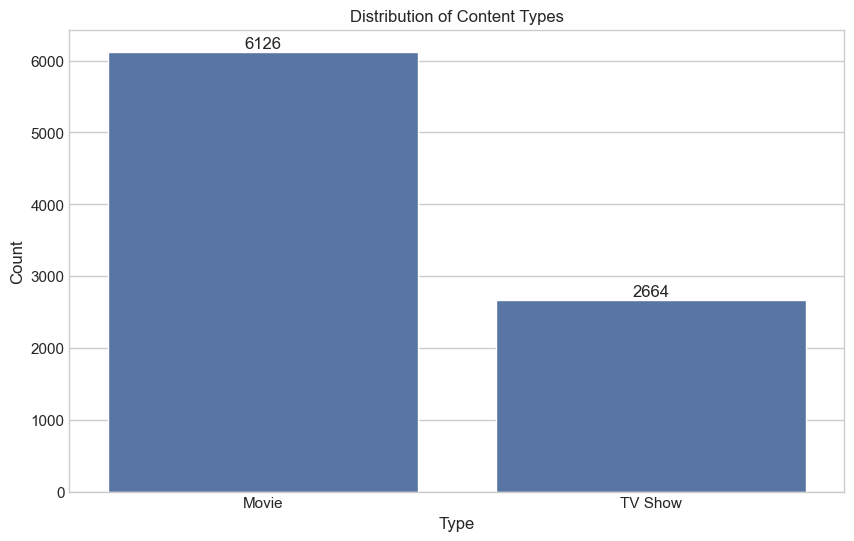


Content Type Distribution:
type
Movie      6126
TV Show    2664
Name: count, dtype: int64


In [33]:
print("\n\nStarting Exploratory Data Analysis...")

# 4.1 Basic Distribution Analysis
# Distribution of content types (Movies vs. TV Shows)
if 'type' in netflix_clean.columns:
    plt.figure(figsize=(10, 6))
    type_counts = netflix_clean['type'].value_counts()
    ax = sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('Distribution of Content Types')
    plt.xlabel('Type')
    plt.ylabel('Count')
    # Add count labels on top of bars
    for i, count in enumerate(type_counts.values):
        ax.text(i, count + 50, f'{count}', ha='center')
    plt.show()

    print("\nContent Type Distribution:")
    print(type_counts)

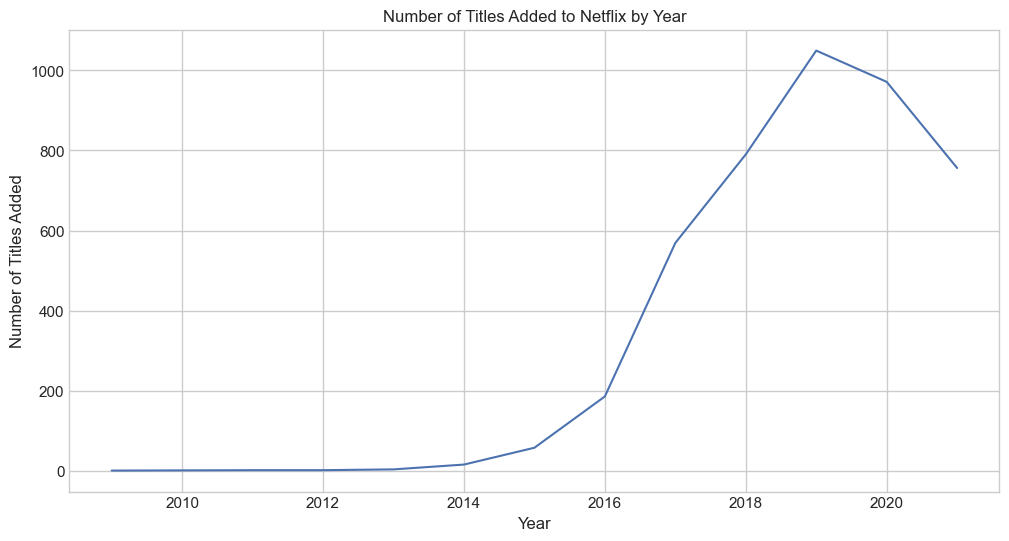

In [34]:
# 4.2 Temporal Analysis
# Content Added Over Time
if 'year_added' in netflix_clean.columns:
    yearly_additions = netflix_clean['year_added'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=yearly_additions.index, y=yearly_additions.values)
    plt.title('Number of Titles Added to Netflix by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Titles Added')
    plt.grid(True)
    plt.show()

<Figure size 1200x600 with 0 Axes>

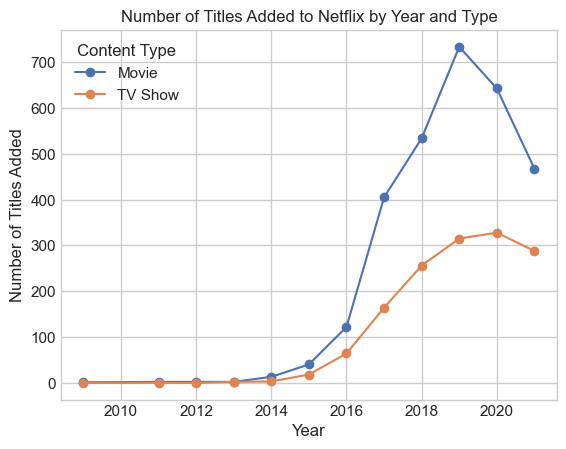

In [35]:
# Breakdown by content type
if 'type' in netflix_clean.columns:
    yearly_by_type = netflix_clean.groupby(['year_added', 'type']).size().unstack().fillna(0)

    plt.figure(figsize=(12, 6))
    yearly_by_type.plot(kind='line', marker='o')
    plt.title('Number of Titles Added to Netflix by Year and Type')
    plt.xlabel('Year')
    plt.ylabel('Number of Titles Added')
    plt.grid(True)
    plt.legend(title='Content Type')
    plt.show()

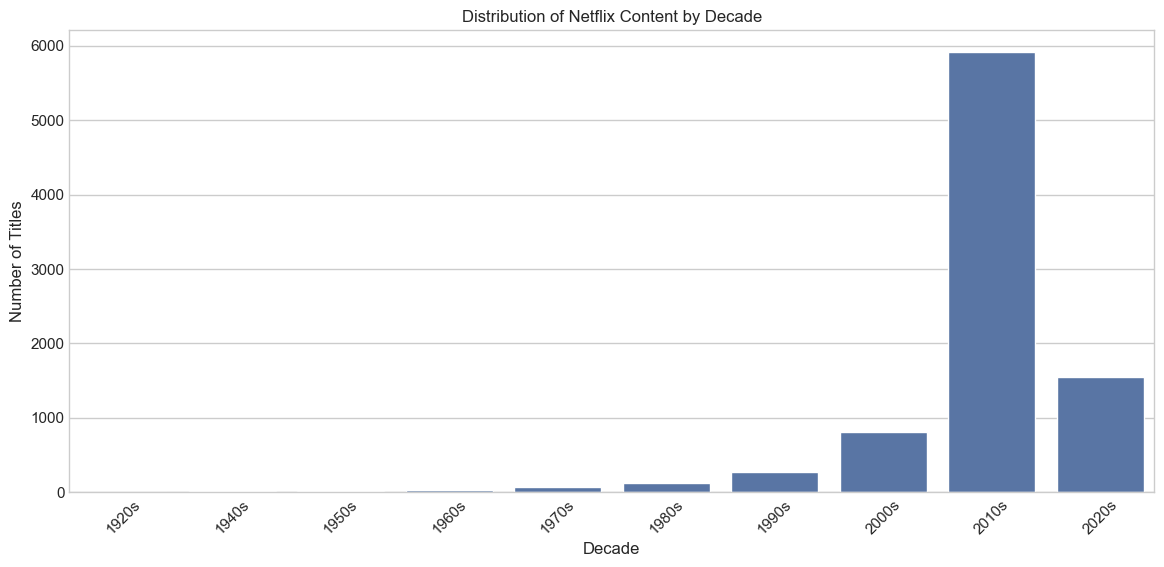

In [36]:
# 4.3 Content Release Year Analysis
if 'release_year' in netflix_clean.columns:
    # Bin release years by decade for better visualization
    plt.figure(figsize=(14, 6))
    decade_counts = netflix_clean['decade'].value_counts().sort_index()
    sns.barplot(x=decade_counts.index, y=decade_counts.values)
    plt.title('Distribution of Netflix Content by Decade')
    plt.xlabel('Decade')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

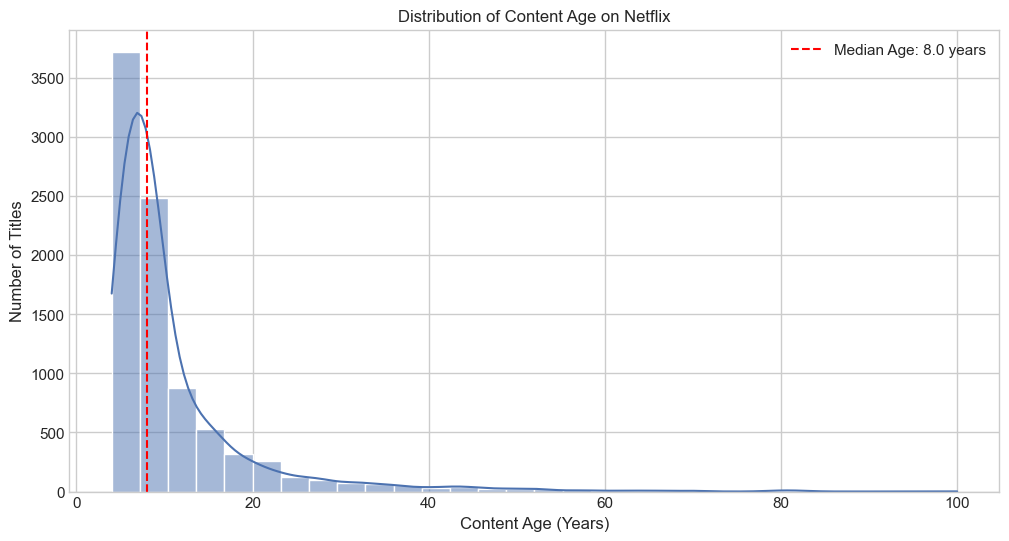

In [37]:
# Content age distribution
if 'content_age' in netflix_clean.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(netflix_clean['content_age'].dropna(), bins=30, kde=True)
    plt.axvline(netflix_clean['content_age'].median(), color='red', linestyle='--',
                label=f'Median Age: {netflix_clean["content_age"].median():.1f} years')
    plt.title('Distribution of Content Age on Netflix')
    plt.xlabel('Content Age (Years)')
    plt.ylabel('Number of Titles')
    plt.legend()
    plt.grid(True)
    plt.show()

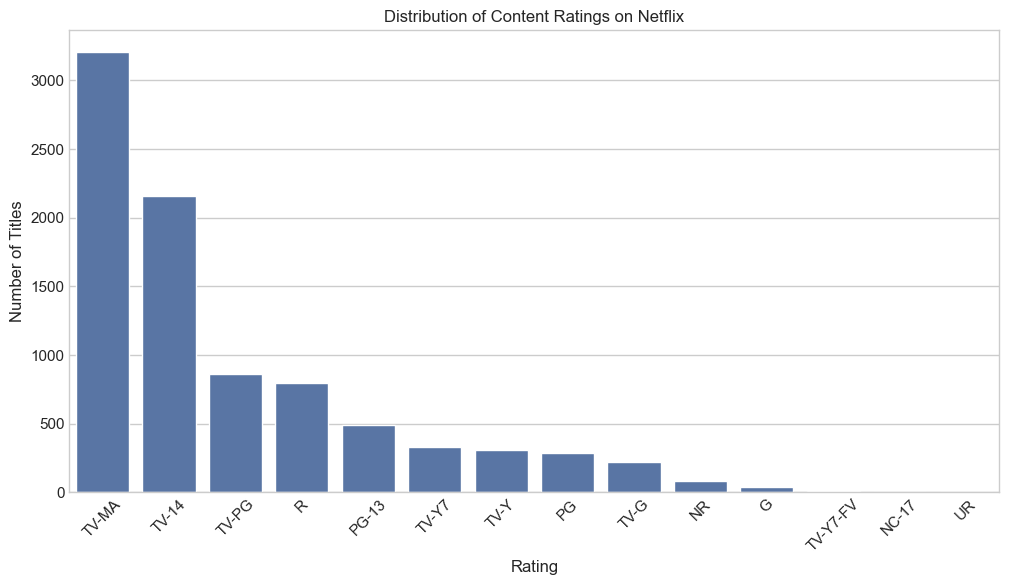

In [38]:
# 4.4 Rating Distribution
if 'rating' in netflix_clean.columns:
    plt.figure(figsize=(12, 6))
    rating_counts = netflix_clean['rating'].value_counts().sort_values(ascending=False)
    sns.barplot(x=rating_counts.index, y=rating_counts.values)
    plt.title('Distribution of Content Ratings on Netflix')
    plt.xlabel('Rating')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

<Figure size 1000x800 with 0 Axes>

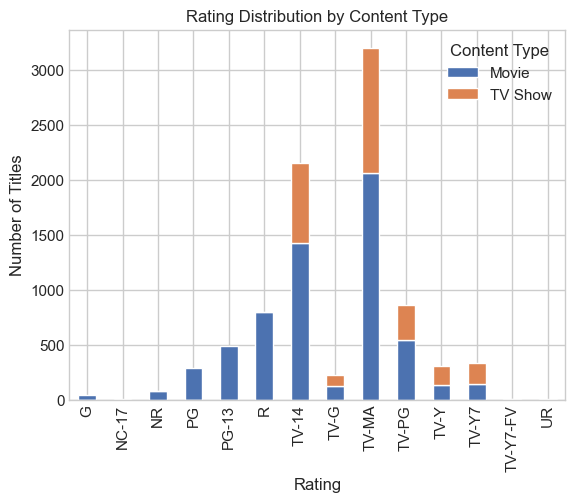

In [39]:
# Rating distribution by content type
plt.figure(figsize=(10, 8))
rating_by_type = pd.crosstab(netflix_clean['rating'], netflix_clean['type'])
rating_by_type.plot(kind='bar', stacked=True)
plt.title('Rating Distribution by Content Type')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.grid(True, axis='y')
plt.legend(title='Content Type')
plt.show()

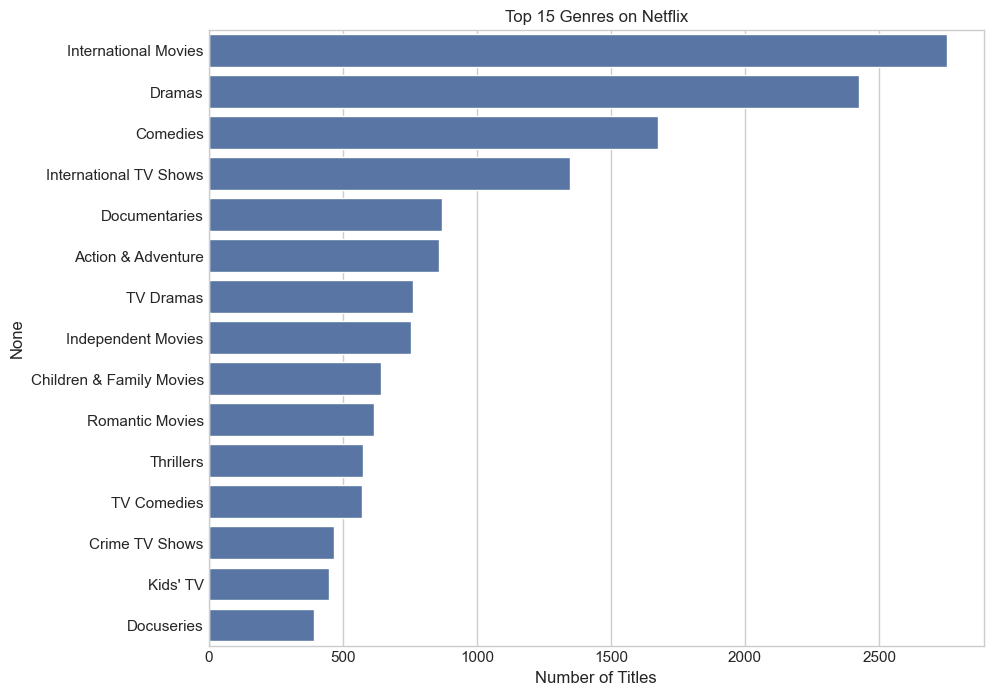

In [40]:
# 4.5 Genre Analysis
if 'genres' in netflix_clean.columns:
    # Get all genres
    all_genres = [genre for sublist in netflix_clean['genres'].dropna() for genre in sublist]
    genre_counts = pd.Series(all_genres).value_counts().nlargest(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Top 15 Genres on Netflix')
    plt.xlabel('Number of Titles')
    plt.grid(True, axis='x')
    plt.show()


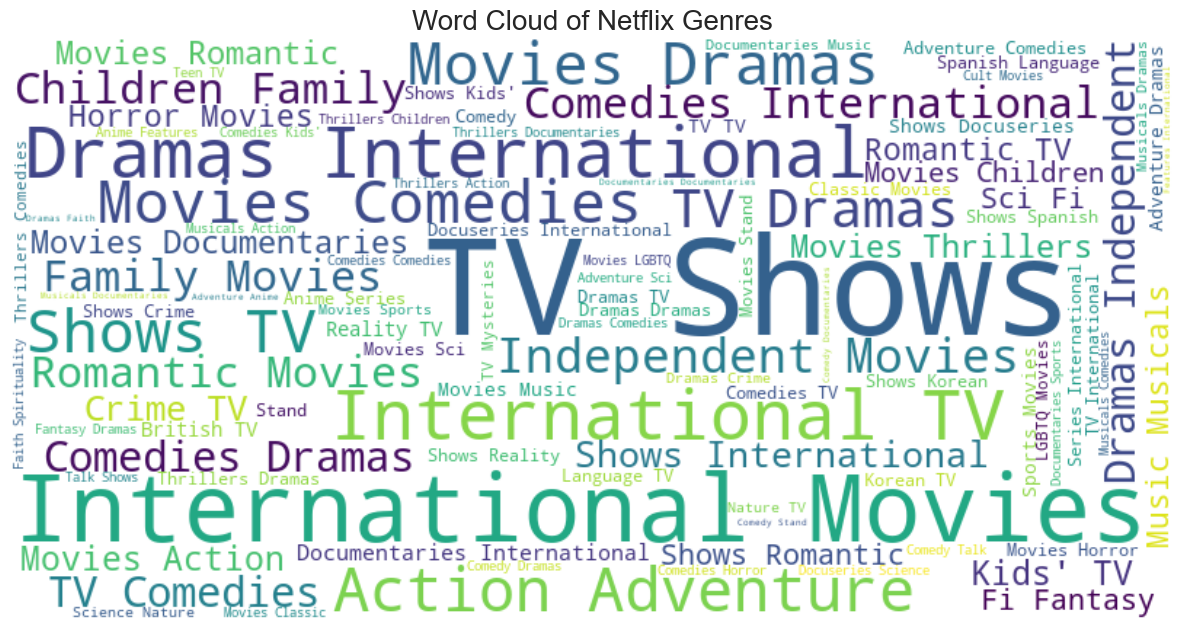

In [41]:
# Create a word cloud of genres
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                        colormap='viridis', max_words=100).generate(' '.join(all_genres))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Netflix Genres', fontsize=20)
plt.tight_layout()
plt.show()

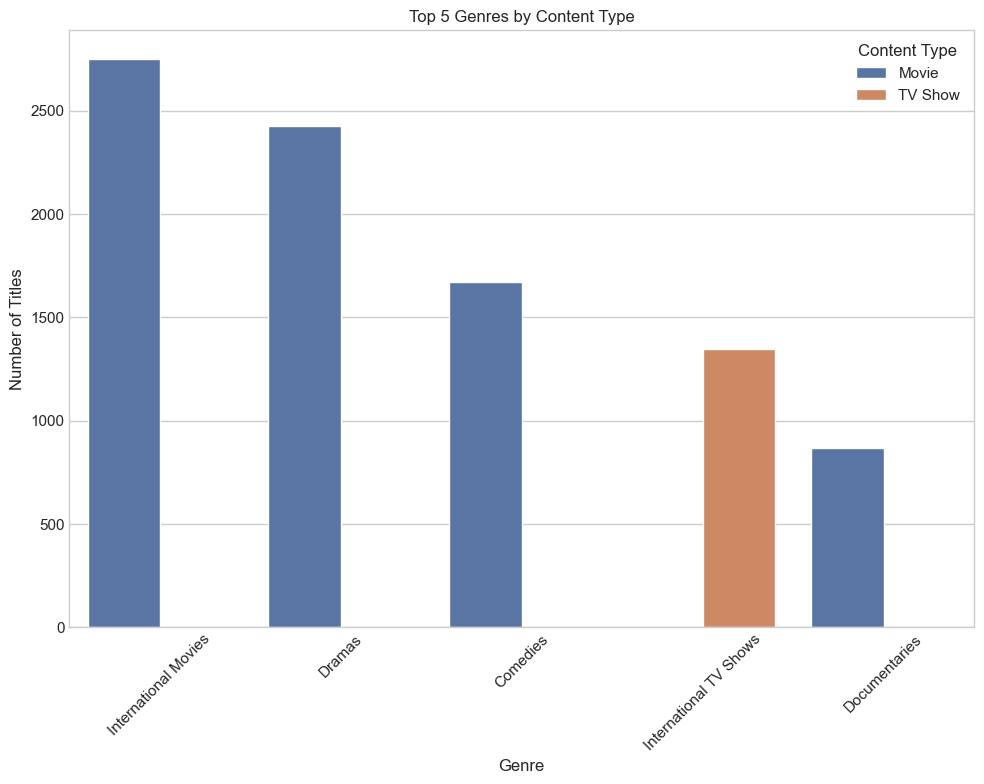

In [42]:
# Genre distribution by content type
top_5_genres = genre_counts.nlargest(5).index

# Create a dataframe for plotting
genre_type_data = []
for genre in top_5_genres:
    for content_type in netflix_clean['type'].unique():
        count = sum(1 for i, row in netflix_clean.iterrows()
                    if isinstance(row['genres'], list) and
                    genre in row['genres'] and
                    row['type'] == content_type)
        genre_type_data.append({'Genre': genre, 'Type': content_type, 'Count': count})

genre_type_df = pd.DataFrame(genre_type_data)

plt.figure(figsize=(10, 8))
sns.barplot(x='Genre', y='Count', hue='Type', data=genre_type_df)
plt.title('Top 5 Genres by Content Type')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.legend(title='Content Type')
plt.tight_layout()
plt.show()

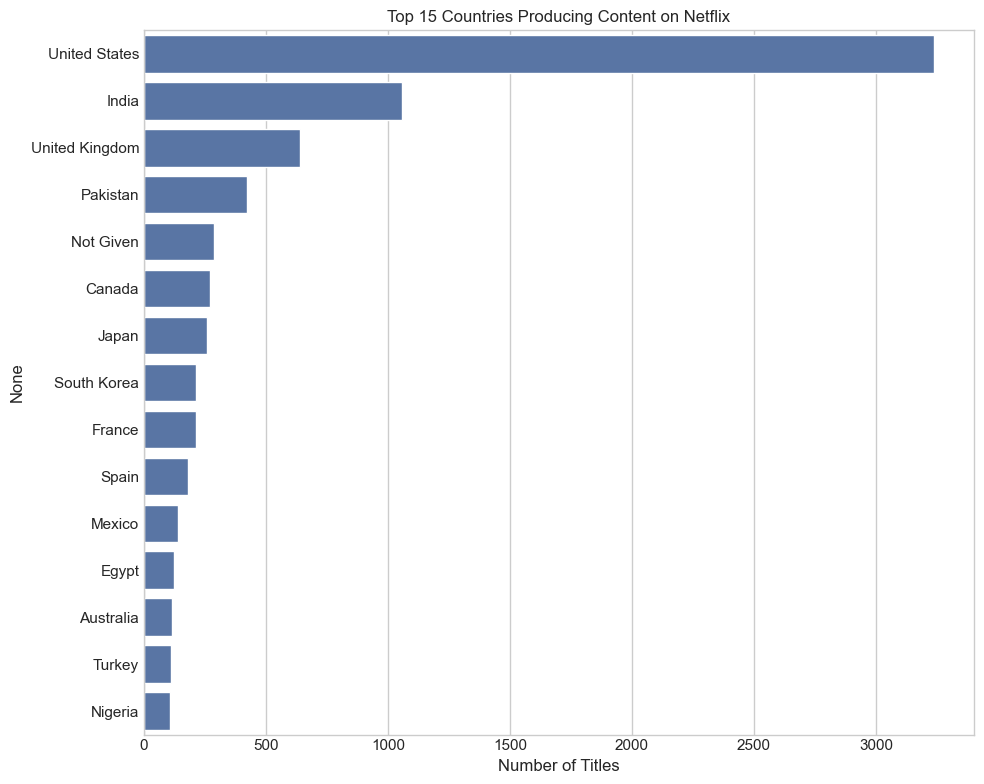

In [43]:
# 4.6 Country/Region Analysis
if 'countries' in netflix_clean.columns:
    # Get all countries
    all_countries = [country for sublist in netflix_clean['countries'].dropna() for country in sublist]
    country_counts = pd.Series(all_countries).value_counts().nlargest(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=country_counts.values, y=country_counts.index)
    plt.title('Top 15 Countries Producing Content on Netflix')
    plt.xlabel('Number of Titles')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

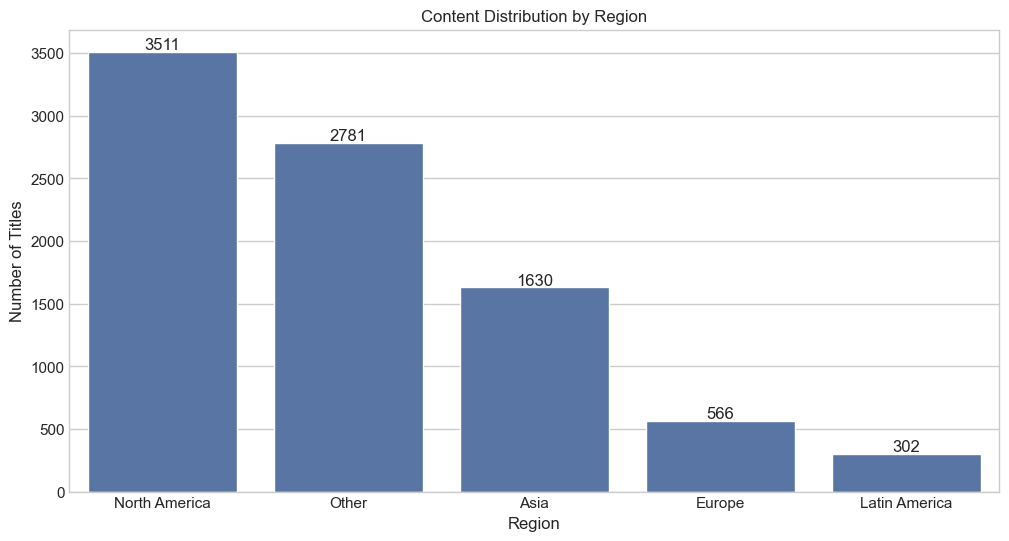

In [44]:
# Region distribution
if 'region' in netflix_clean.columns:
    plt.figure(figsize=(12, 6))
    region_counts = netflix_clean['region'].value_counts()
    ax = sns.barplot(x=region_counts.index, y=region_counts.values)
    plt.title('Content Distribution by Region')
    plt.xlabel('Region')
    plt.ylabel('Number of Titles')
    # Add count labels on top of bars
    for i, count in enumerate(region_counts.values):
        ax.text(i, count + 20, f'{count}', ha='center')
    plt.show()

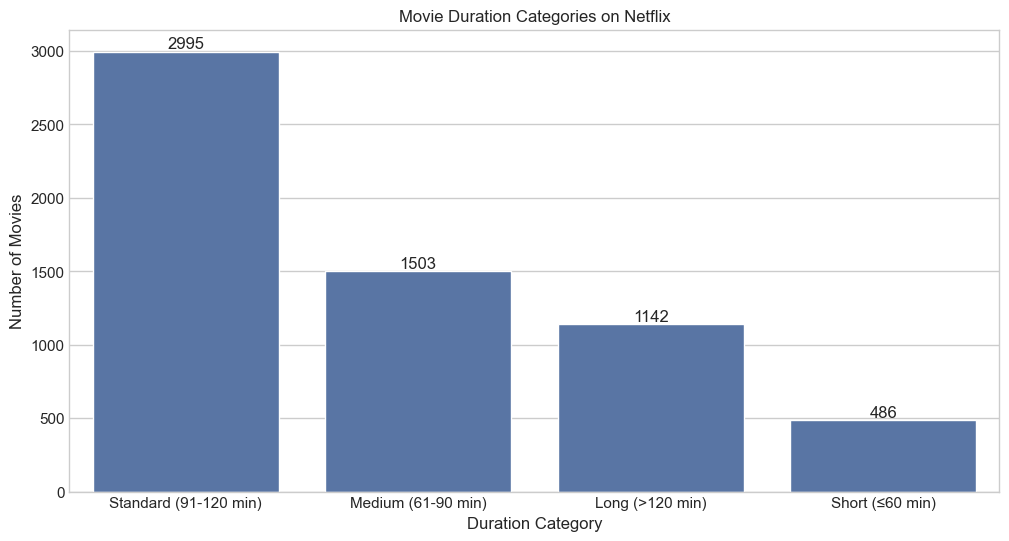

In [45]:
# 4.7 Duration Analysis
if 'duration_category' in netflix_clean.columns:
    plt.figure(figsize=(12, 6))
    duration_counts = netflix_clean[netflix_clean['type'] == 'Movie']['duration_category'].value_counts()
    ax = sns.barplot(x=duration_counts.index, y=duration_counts.values)
    plt.title('Movie Duration Categories on Netflix')
    plt.xlabel('Duration Category')
    plt.ylabel('Number of Movies')
    # Add count labels on top of bars
    for i, count in enumerate(duration_counts.values):
        ax.text(i, count + 20, f'{count}', ha='center')
    plt.grid(True, axis='y')
    plt.show()


In [46]:
# 4.8 Content Description Analysis
if 'description_cleaned' in netflix_clean.columns:
    # Combine all descriptions
    all_descriptions = ' '.join(netflix_clean['description_cleaned'].dropna())

    # Remove common stopwords
    try:
        nltk.download('stopwords', quiet=True)
        stop_words = set(stopwords.words('english'))

        # Tokenize
        words = word_tokenize(all_descriptions)

        # Remove stopwords and short words
        filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 3]

        # Get word frequencies
        word_freq = Counter(filtered_words)

        # Create word cloud
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                             colormap='plasma', max_words=100).generate(' '.join(filtered_words))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Netflix Content Descriptions', fontsize=20)
        plt.tight_layout()
        plt.show()
    except:
        print("NLTK resources not available, skipping description word cloud")

# 5. Building the Recommendation System

In [48]:
print("\n\nBuilding Content-Based Recommendation System...")

# 5.1 TF-IDF Vectorization of Content Features
print("\n5.1 Creating TF-IDF Vectors from Content Features")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

# Fit and transform the content soup
tfidf_matrix = tfidf.fit_transform(netflix_clean['content_soup'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features extracted: {len(tfidf.get_feature_names_out())}")

# Sample of features
print(f"\nSample of extracted features:")
print(tfidf.get_feature_names_out()[:20])



Building Content-Based Recommendation System...

5.1 Creating TF-IDF Vectors from Content Features
TF-IDF matrix shape: (8790, 20602)
Number of features extracted: 20602

Sample of extracted features:
['aadish' 'aadish keluskar' 'aamir' 'aamir bashir' 'aamir khan' 'aanand'
 'aanand rai' 'aaron' 'aaron burns' 'aaron hancox' 'aaron hann'
 'aaron lieber' 'aaron moorhead' 'aaron nee' 'aaron sorkin'
 'aaron woodley' 'aaron woolf' 'aatmaram' 'aatmaram dharne' 'abad']


In [49]:
# 5.2 Compute Cosine Similarity Matrix
print("\n5.2 Computing Cosine Similarity Matrix")

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Cosine similarity matrix shape: {cosine_sim.shape}")


5.2 Computing Cosine Similarity Matrix
Cosine similarity matrix shape: (8790, 8790)


In [50]:
# 5.3 Create Recommendation Function
print("\n5.3 Creating Recommendation Function")

# Create a Series with index matching titles and content for easier lookup
indices = pd.Series(netflix_clean.index, index=netflix_clean['title']).drop_duplicates()

# Function to get recommendations based on cosine similarity
def get_recommendations(title, cosine_sim=cosine_sim, df=netflix_clean, indices=indices, top_n=10):
    # Get the index of the movie that matches the title
    try:
        idx = indices[title]
    except:
        return f"Title '{title}' not found in the database."

    # Get the similarity scores for all titles (pairwise similarity with the input title)
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the titles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N most similar titles (excluding the input title itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get the title indices
    movie_indices = [i[0] for i in sim_scores]

    # Create a dataframe with recommended titles and similarity scores
    recommendations = pd.DataFrame({
        'Title': df['title'].iloc[movie_indices],
        'Type': df['type'].iloc[movie_indices],
        'Genres': df['listed_in'].iloc[movie_indices],
        'Similarity Score': [i[1] for i in sim_scores]
    })

    return recommendations

# Test the recommendation function with a sample title
sample_title = netflix_clean['title'].iloc[0]
print(f"\nGenerating recommendations for sample title: '{sample_title}'")

recommendations = get_recommendations(sample_title)
print("\nTop 10 recommendations:")
print(recommendations.to_string())


5.3 Creating Recommendation Function

Generating recommendations for sample title: 'Dick Johnson Is Dead'

Top 10 recommendations:
                                  Title   Type                                           Genres  Similarity Score
1748               The Debt Collector 2  Movie                               Action & Adventure          0.314834
3796                       Carrie Pilby  Movie                                 Comedies, Dramas          0.298558
5795                           S.W.A.T.  Movie                               Action & Adventure          0.296552
3496                   Alex Strangelove  Movie             Comedies, Dramas, Independent Movies          0.292509
5279             Kung Fu Panda: Holiday  Movie               Children & Family Movies, Comedies          0.288868
3403  To All the Boys I’ve Loved Before  Movie  Comedies, International Movies, Romantic Movies          0.284135
5828                         Savage Dog  Movie           Action & Adve

In [51]:
# 5.4 KNN-Based Recommendation System (Alternative Approach)
print("\n5.4 Building KNN-Based Recommendation System")

# Use the same TF-IDF matrix
# Apply K-Nearest Neighbors
knn_model = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine')
knn_model.fit(tfidf_matrix)

# Function to get recommendations using KNN
def get_knn_recommendations(title, knn_model=knn_model, df=netflix_clean, indices=indices, top_n=10):
    try:
        idx = indices[title]
    except:
        return f"Title '{title}' not found in the database."

    # Get the K nearest neighbors
    distances, indices_knn = knn_model.kneighbors(tfidf_matrix[idx].reshape(1, -1))

    # Convert to lists and remove the first element (the title itself)
    distances = distances.flatten().tolist()[1:top_n+1]
    indices_knn = indices_knn.flatten().tolist()[1:top_n+1]

    # Create a dataframe with recommended titles and distance scores
    recommendations = pd.DataFrame({
        'Title': df['title'].iloc[indices_knn],
        'Type': df['type'].iloc[indices_knn],
        'Genres': df['listed_in'].iloc[indices_knn],
        'Distance Score': distances
    })

    # Sort by distance (smaller is better)
    recommendations = recommendations.sort_values('Distance Score')

    return recommendations

# Test the KNN recommendation function with the same sample title
print(f"\nGenerating KNN recommendations for sample title: '{sample_title}'")

knn_recommendations = get_knn_recommendations(sample_title)
print("\nTop 10 KNN recommendations:")
print(knn_recommendations.to_string())


5.4 Building KNN-Based Recommendation System

Generating KNN recommendations for sample title: 'Dick Johnson Is Dead'

Top 10 KNN recommendations:
                                  Title   Type                                           Genres  Distance Score
1748               The Debt Collector 2  Movie                               Action & Adventure        0.685166
3796                       Carrie Pilby  Movie                                 Comedies, Dramas        0.701442
5795                           S.W.A.T.  Movie                               Action & Adventure        0.703448
3496                   Alex Strangelove  Movie             Comedies, Dramas, Independent Movies        0.707491
5279             Kung Fu Panda: Holiday  Movie               Children & Family Movies, Comedies        0.711132
3403  To All the Boys I’ve Loved Before  Movie  Comedies, International Movies, Romantic Movies        0.715865
5828                         Savage Dog  Movie           Action & Ad

In [52]:
# 5.5 Dimensionality Reduction and Visualization
print("\n5.5 Dimensionality Reduction for Content Visualization")

# Apply Truncated SVD to reduce dimensions of TF-IDF matrix to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_features = svd.fit_transform(tfidf_matrix)

# Add the reduced dimensions to the dataframe
netflix_clean['component_1'] = reduced_features[:, 0]
netflix_clean['component_2'] = reduced_features[:, 1]

# Plot using Plotly for interactivity
fig = px.scatter(netflix_clean, x='component_1', y='component_2',
                 color='type', hover_data=['title', 'listed_in'],
                 title='Netflix Titles Visualized in 2D via Truncated SVD',
                 template='plotly_white')
fig.show()


5.5 Dimensionality Reduction for Content Visualization


In [53]:
# Save cleaned data and recommendations model (optional)
netflix_clean.to_csv('netflix_cleaned.csv', index=False)
print("\nCleaned dataset saved to 'netflix_cleaned.csv'")


Cleaned dataset saved to 'netflix_cleaned.csv'


In [54]:
print("\n\nConclusion:")
print("✅ Successfully cleaned and explored the Netflix dataset.")
print("✅ Built a robust content-based recommendation system using TF-IDF and Cosine Similarity.")
print("✅ Alternative recommendation model built using KNN.")
print("✅ Visualized Netflix titles in 2D using Truncated SVD.")



Conclusion:
✅ Successfully cleaned and explored the Netflix dataset.
✅ Built a robust content-based recommendation system using TF-IDF and Cosine Similarity.
✅ Alternative recommendation model built using KNN.
✅ Visualized Netflix titles in 2D using Truncated SVD.
